# Problem

- To predict what kind of contraceptive measurements are taken 
- We shall use neural network to solve this classification problem.

# 1)- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Concatenate,Add, Flatten
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [3]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

In [4]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# 2)- Loading and preparing Data

In [5]:
df = pd.read_csv('cmc.data.txt',header=None,names=['Age','Education','H_education',
                                                     'num_child','Religion', 'Employ',
                                                     'H_occupation','living_standard',
                                                     'Media_exposure','contraceptive'])
df.shape

(1473, 10)

In [6]:
df.head()

,Age,Education,H_education,num_child,Religion,Employ,H_occupation,living_standard,Media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [7]:
df.dtypes

Age                int64
Education          int64
H_education        int64
num_child          int64
Religion           int64
Employ             int64
H_occupation       int64
living_standard    int64
Media_exposure     int64
contraceptive      int64
dtype: object

### 2.1. Checking missing values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              1473 non-null   int64
 1   Education        1473 non-null   int64
 2   H_education      1473 non-null   int64
 3   num_child        1473 non-null   int64
 4   Religion         1473 non-null   int64
 5   Employ           1473 non-null   int64
 6   H_occupation     1473 non-null   int64
 7   living_standard  1473 non-null   int64
 8   Media_exposure   1473 non-null   int64
 9   contraceptive    1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB


In [9]:
df.isnull().sum()

Age                0
Education          0
H_education        0
num_child          0
Religion           0
Employ             0
H_occupation       0
living_standard    0
Media_exposure     0
contraceptive      0
dtype: int64

In [10]:
df.contraceptive.value_counts()

1    629
3    511
2    333
Name: contraceptive, dtype: int64

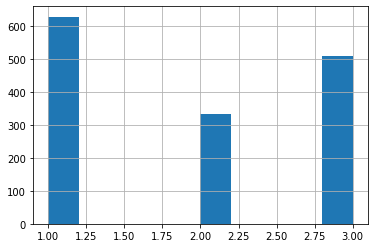

In [11]:
df.contraceptive.hist()

### 2.2.one_hot_encoding

In [12]:
def one_hot_encoding(idx):
    y = np.zeros((len(idx),max(idx)+1))
    y[np.arange(len(idx)), idx] = 1
    return y

### 2.3.Scaling

In [13]:
scaler = StandardScaler()
df[['Age','num_child']] = scaler.fit_transform(df[['Age','num_child']])

In [14]:
df.describe()

,Age,Education,H_education,num_child,Religion,Employ,H_occupation,living_standard,Media_exposure,contraceptive
count,1.473000e+03,1473.000000,1473.000000,1.473000e+03,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,2.990743e-16,2.958588,3.429735,-7.235669e-18,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891
std,1.000340e+00,1.014994,0.816349,1.000340e+00,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376
min,-2.010877e+00,1.000000,1.000000,-1.383257e+00,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,-7.949900e-01,2.000000,3.000000,-9.591234e-01,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,-6.545811e-02,3.000000,4.000000,-1.108563e-01,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,7.856625e-01,4.000000,4.000000,3.132772e-01,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,2.001549e+00,4.000000,4.000000,5.402879e+00,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


Notice Age and number of children are negative. In practice, it is not possible but, it is done to scale int values provided in these features.

In [15]:
x = df[['Age','num_child','Employ','Media_exposure']].values
y = one_hot_encoding(df.contraceptive.values-1)

liv_cats = df.living_standard.max()
edu_cats = df.Education.max()

liv = df.living_standard.values - 1
liv_one_hot = one_hot_encoding(liv)
edu = df.Education.values - 1
edu_one_hot = one_hot_encoding(edu)

### 2.4.train-test split

In [16]:
train_x, test_x, train_liv, \
test_liv, train_edu, test_edu, train_y, test_y = train_test_split(x,liv_one_hot,edu_one_hot,y,test_size=0.1, random_state=1)

In [17]:
print(train_x.shape)
print(test_x.shape)
print(train_liv.shape)
print(test_liv.shape)
print(train_edu.shape)
print(test_edu.shape)
print(train_y.shape)
print(test_y.shape)

(1325, 4)
(148, 4)
(1325, 4)
(148, 4)
(1325, 4)
(148, 4)
(1325, 3)
(148, 3)


combining education and living standard variables in main train and test set

In [18]:
train_x = np.hstack([train_x, train_edu, train_liv])
test_x = np.hstack([test_x, test_edu, test_liv])
print(train_x.shape)
print(test_x.shape)

(1325, 12)
(148, 12)


# 3-Basic level Model

In [19]:
train_x.shape[1]

12

In [20]:
df.contraceptive.nunique()

3

### 3.1.Defining parameters

In [21]:
input_dim=train_x.shape[1]
output_dim=df.contraceptive.nunique()
epoch=100
batch=8

### 3.2.Defining Network Structure

In [22]:
model = Sequential()
model.add(Dense(12,input_dim=train_x.shape[1])) # 12 is size of dense hidden layer, input dim. is also 12.
model.add(Activation('relu'))
model.add(Dense(output_dim=output_dim))
model.add(Activation('softmax'))

In [23]:
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 39        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


- So at step1 : 12*12 + 12 = 156 <br>
This is between input layer and hidden layer. meaning we have 12 input dim.s and 12 neurons in hidden layer. So, multiplying them. then we have 12 biases from 12 neuron hence, adding them as well.
- at step3: 3*12 + 3 <br>
this is between hidden layer and output layer meaning we have 12 weights coming out of hidden layer and they will act as input now. We have 3 dim. of output layer so 3 multipy by 12. Then we have 3 biases coming from 3 neurons of output layers. 

In [25]:
# calculation can be undersood by all steps
for w in model.get_weights():
    print(w.shape)

(12, 12)
(12,)
(12, 3)
(3,)


- In total we have 4 steps. We only get computation of W and b at step1 and 3. Two other steps compute activation funtions.

- Difference is summary is that it has 5 steps to show as last step is activation function.
- For get_weights, we see what weights are on each step of layers i.e 1.input and dense layer weights, 2. biase at dense layer added, 3.dense layer and output layer weights, 4. biase at output layer 

### 3.3.fit the model

- verbose

By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.<br>

- verbose=0 will show you nothing (silent)

- verbose=1 will show you an animated progress bar like this:<br>

progres_bar

- verbose=2 will just mention the number of epoch like this:<br>

epoch 1/100

In [26]:
model.fit(train_x, train_y, nb_epoch=epoch,batch_size=batch, verbose=2)

Epoch 1/100
 - 0s - loss: 1.0503 - accuracy: 0.4174
Epoch 2/100
 - 0s - loss: 1.0094 - accuracy: 0.4657
Epoch 3/100
 - 0s - loss: 0.9941 - accuracy: 0.4702
Epoch 4/100
 - 0s - loss: 0.9841 - accuracy: 0.4755
Epoch 5/100
 - 0s - loss: 0.9762 - accuracy: 0.4830
Epoch 6/100
 - 0s - loss: 0.9697 - accuracy: 0.4906
Epoch 7/100
 - 0s - loss: 0.9641 - accuracy: 0.4974
Epoch 8/100
 - 0s - loss: 0.9593 - accuracy: 0.4943
Epoch 9/100
 - 0s - loss: 0.9550 - accuracy: 0.5019
Epoch 10/100
 - 0s - loss: 0.9511 - accuracy: 0.5064
Epoch 11/100
 - 0s - loss: 0.9476 - accuracy: 0.5162
Epoch 12/100
 - 0s - loss: 0.9443 - accuracy: 0.5321
Epoch 13/100
 - 0s - loss: 0.9412 - accuracy: 0.5434
Epoch 14/100
 - 0s - loss: 0.9380 - accuracy: 0.5464
Epoch 15/100
 - 0s - loss: 0.9351 - accuracy: 0.5555
Epoch 16/100
 - 0s - loss: 0.9323 - accuracy: 0.5615
Epoch 17/100
 - 0s - loss: 0.9296 - accuracy: 0.5585
Epoch 18/100
 - 0s - loss: 0.9271 - accuracy: 0.5577
Epoch 19/100
 - 0s - loss: 0.9248 - accuracy: 0.5585
Ep

# 4- Model Evaluation

In [27]:
score = model.evaluate(test_x, test_y,
                       batch_size=batch)
print('Test accuracy:', score[1])

148/148 [==============================] - 0s 128us/step
Test accuracy: 0.5945945978164673


On test data, we get higher accuracy than training data.

### 4.1.probability distribution

In [28]:
y_pred=model.predict(test_x)
y_pred[:5]

array([[0.27659097, 0.3031548 , 0.42025417],
       [0.7828973 , 0.10039046, 0.11671227],
       [0.24064758, 0.16997321, 0.5893792 ],
       [0.44398442, 0.3544062 , 0.20160937],
       [0.7209546 , 0.12301193, 0.15603353]], dtype=float32)

### 4.2.prediction classes

In [29]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(test_y,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [30]:
#true claesses
y_test_class[:5]

array([0, 0, 2, 0, 0], dtype=int64)

In [31]:
#predicted classes
y_pred_class[:5]

array([2, 0, 2, 0, 0], dtype=int64)

### 4.3.weight performance of each step

In [32]:
a = model.get_weights()
a

[array([[-0.4868305 ,  0.5758508 ,  0.69801813,  0.06488978,  0.30670866,
         -0.4495593 , -0.14124537,  0.31386882,  0.6893727 , -0.17765318,
          0.14431919,  0.13832472],
        [ 0.3792551 ,  0.5005043 , -0.12553741,  0.2844328 , -0.8979327 ,
         -0.07528007,  0.10422943, -0.03617512, -0.08558214, -0.549503  ,
         -0.42476556, -0.9498079 ],
        [-0.01381412, -0.40281686,  0.19423242, -0.3457703 , -0.25569028,
          0.23048057, -0.05447122,  0.09585739, -0.12762864, -0.4470554 ,
          0.32296336,  0.26520142],
        [-0.02045248, -0.01715326,  0.6257382 , -0.32715824,  0.07146992,
          0.3123249 ,  0.32078832,  0.14584295,  0.13889214, -0.14512844,
         -0.00249851,  0.24065669],
        [ 0.06806789,  0.06659345,  0.17989822,  0.20276032,  0.24392037,
         -0.08845601,  0.5185902 ,  0.07665098,  0.6407426 , -0.31759295,
          0.26000533, -0.16841882],
        [-0.33096522,  0.45013732,  0.1998777 ,  0.1542275 ,  0.10773113,
      

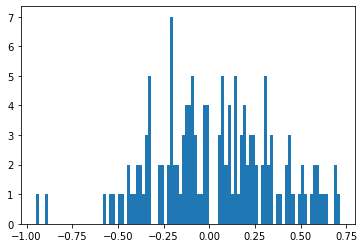

In [33]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

We ideally seek for a bell shape curve. Here , we can see somewhat a broken sequence of weights over the model

# END OF NOTEBOOK